In [1]:
import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from cellpose import utils, io
from cellpose import models
from cellpose.io import imread
from cellpose import plot

In [2]:
def show_segmentation_mod(fig, img, maski, nsegmentation = 0, channels=[0,0], file_name=None):
    """ plot segmentation results (like on website)
    
    Can save each panel of figure with file_name option. Use channels option if
    img input is not an RGB image with 3 channels.
    
    Parameters
    -------------

    fig: matplotlib.pyplot.figure
        figure in which to make plot

    img: 2D or 3D array
        image input into cellpose

    maski: int, 2D array
        for image k, masks[k] output from Cellpose.eval, where 0=NO masks; 1,2,...=mask labels

    flowi: int, 2D array 
        for image k, flows[k][0] output from Cellpose.eval (RGB of flows)

    channels: list of int (optional, default [0,0])
        channels used to run Cellpose, no need to use if image is RGB

    file_name: str (optional, default None)
        file name of image, if file_name is not None, figure panels are saved
        
    seg_norm: bool (optional, default False)
        improve cell visibility under labels
        

    """

    nrow = nsegmentation + 1
    ax = fig.add_subplot(nrow,4,1)
    img0 = img.copy()

    if img0.shape[0] < 4:
        img0 = np.transpose(img0, (1,2,0))
    if img0.shape[-1] < 3 or img0.ndim < 3:
        img0 = plot.image_to_rgb(img0, channels=channels)
    else:
        if img0.max()<=50.0:
            img0 = np.uint8(np.clip(img0*255, 0, 1))
    ax.imshow(img0)
    ax.set_title('original image')
    ax.axis('off')

    outlines = utils.masks_to_outlines(maski)

    overlay = plot.mask_overlay(img0, maski)

    ax = fig.add_subplot(nrow,4,2)
    outX, outY = np.nonzero(outlines)
    imgout= img0.copy()
    imgout[outX, outY] = np.array([255,0,0]) # pure red

    ax.imshow(imgout)
    ax.set_title('predicted outlines')
    ax.axis('off')

    ax = fig.add_subplot(nrow,4,3)
    ax.imshow(overlay)
    ax.set_title('predicted masks')
    ax.axis('off')

    if file_name is not None:
        save_path = os.path.splitext(file_name)[0]
        io.imsave(save_path + '_overlay.jpg', overlay)
        io.imsave(save_path + '_outlines.jpg', imgout)


In [11]:
# set paths
im_dir = "C:\\Users\\Simon Andersen\\Documents\\Uni\\SummerProject\\data\\valeriias mdck data for simon\\24.08.22_698x648"
cellpose_folder_path = "C:\\Users\\Simon Andersen\\miniconda3\\envs\\cellpose\\lib\\site-packages\\cellpose"
class_path = 'C:\\Users\\Simon Andersen\\Projects\\Projects\\CellSegmentationTracker\\cellsegmentationtracker'

# get all files in folder
im_list = glob.glob(os.path.join(im_dir, '*.tif'))

img_list = [img for img in imread(im_list[-1])][:3]

100%|██████████| 11/11 [00:00<00:00, 1052.67it/s]


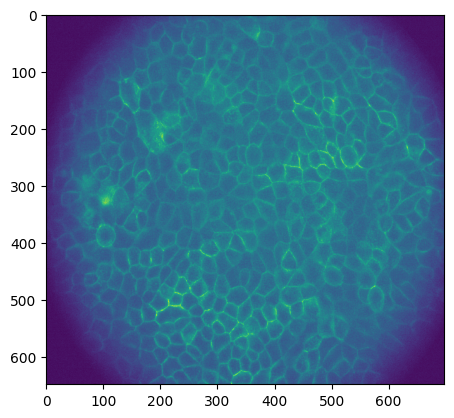

In [10]:
# visualize
plt.imshow(imgs[0])

In [14]:
# set params 
pretrained_models_paths = [os.path.join(cellpose_folder_path, 'models', 'cyto'), \
                                        os.path.join(cellpose_folder_path, 'models', 'cyto2'),\
                                        os.path.join(cellpose_folder_path, 'models', 'nuclei'), \
                                        os.path.join(class_path, 'models', 'epi500'), \
                                        os.path.join(class_path, 'models', 'epi2500'), \
                                            os.path.join(class_path, 'models', 'epi6000')]

flow_threshold = 0.4
cellprob_threshold = 0.0
cp_model = 'cyto2'
use_model = 'CYTO2'
model_path = pretrained_models_paths[-2] if not use_model in ['CYTO', 'CYTO2', 'NUCELI'] else None

cp_kwargs = dict(gpu=True, pretrained_model=model_path, model_type=cp_model, \
                 net_avg=False, diam_mean=30, device=None, residual_on=True, \
                 style_on=True, concatenation=False, nchan=2)

Approach 1 for estimating cell diameters:

In [ ]:
diam_model = models.Cellpose(gpu=True, model_type='cyto2')
masks, flows, styles, diams = diam_model.eval(img_list, diameter=None, channels=[0,0])

Approach 2 for estimating cell diameters:

In [ ]:
size_model_path = models.size_model_path(model_type=cp_model)

# instantiate model and size model
model = models.CellposeModel(**cp_kwargs)
size_model = models.SizeModel(cp_model=model, pretrained_size=size_model_path)
# evaluate model
diams, diam_styles = size_model.eval(img_list, channels=[0,0]) 

STARTING SEGMENTATION OF IMAGE  0
MODEL:  <cellpose.models.CellposeModel object at 0x000002BA178A2C40>
PARAMETERS: 
diameter =  29.68302149304772
flow_threshold =  0.4
cellprob_threshold =  0.0
SEGMENTATION COMPLETETD IN :  5.5  SECONDS


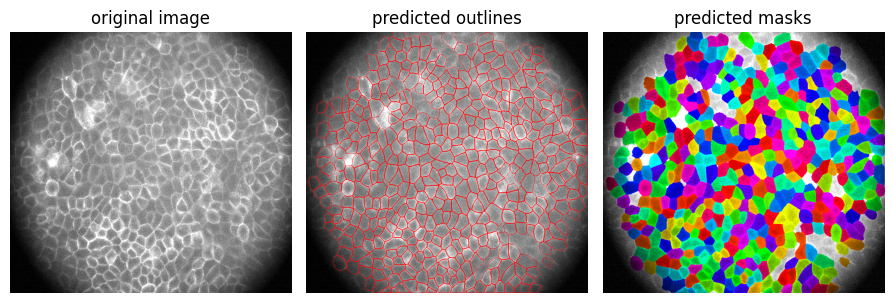

STARTING SEGMENTATION OF IMAGE  1
MODEL:  <cellpose.models.CellposeModel object at 0x000002BA178A2C40>
PARAMETERS: 
diameter =  29.918011296689148
flow_threshold =  0.4
cellprob_threshold =  0.0
SEGMENTATION COMPLETETD IN :  5.3  SECONDS


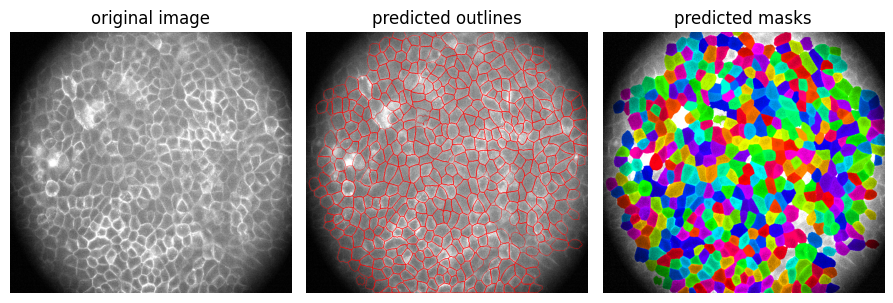

STARTING SEGMENTATION OF IMAGE  2
MODEL:  <cellpose.models.CellposeModel object at 0x000002BA178A2C40>
PARAMETERS: 
diameter =  31.45325303143097
flow_threshold =  0.4
cellprob_threshold =  0.0
SEGMENTATION COMPLETETD IN :  5.0  SECONDS


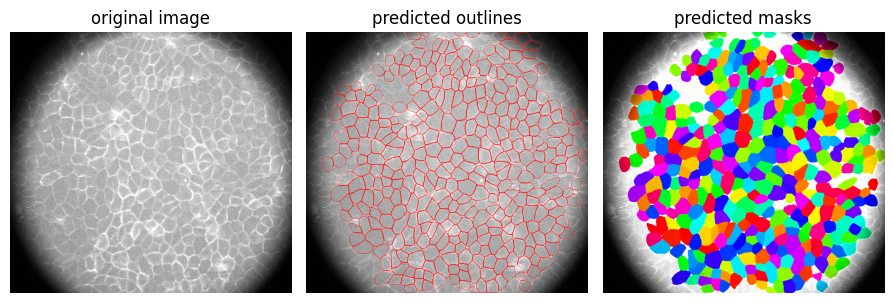

In [20]:
for i, im in enumerate(img_list):
    
    print("STARTING SEGMENTATION OF IMAGE ", i)
    print("MODEL: ", model)
    print("PARAMETERS: ",)
    print("diameter = ", diams[i])
    print("flow_threshold = ", flow_threshold)
    print("cellprob_threshold = ", cellprob_threshold)
    print("===============================================")

    t1 = time.time()
    masks, flows, styles = model.eval(im, diameter=diams[i], cellprob_threshold = cellprob_threshold, flow_threshold = flow_threshold, channels=[0,0])
    t2 = time.time()
    
    print("SEGMENTATION COMPLETETD IN : ", np.round(t2-t1,1), " SECONDS")
    print("===============================================")

    fig = plt.figure(figsize=(12,5))
    show_segmentation_mod(fig, im, masks, channels=[0,0])

    # save segmentation
    save_path = os.path.splitext(im_list[0])[0] + f'_seg_img{i}_diam{np.round(diams[i],3)}_flow{flow_threshold}_cellprob{cellprob_threshold}.png'
    plt.savefig(save_path, dpi=420, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

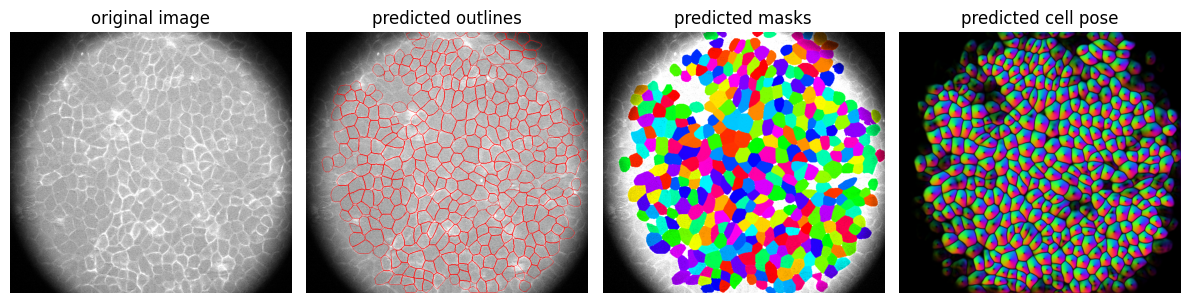

In [22]:
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_list[-1], masks, flows[0], channels=[0,0])
plt.tight_layout()
plt.show()